# Mapeo pro-bono: Prototipo 1
## Importar dependencias

In [2]:
import pandas as pd
import geopandas as gpd
import re
import math

## Importar regiones geograficas

In [10]:
region_dataframes = [
    gpd.read_file('../regions/Apodaca/AgebsDentrodeApodaca.shp').to_crs('WGS 84'),
    gpd.read_file('../regions/Escobedo/AgebsDentrodeEscobedo.shp').to_crs('WGS 84'),
    gpd.read_file('../regions/Garcia/AgebsDentrodeGarcia.shp').to_crs('WGS 84'),
    gpd.read_file('../regions/Juarez/AgebsDentrodeJuarez.shp').to_crs('WGS 84'),
    gpd.read_file('../regions/Monterrey/AgebsDentrodeMonterrey.shp').to_crs('WGS 84'),
    gpd.read_file('../regions/San Nicolas/AgebsDentroSanNicolas.shp').to_crs('WGS 84'),
    gpd.read_file('../regions/San Pedro/AgebsDentrodeSanPedro.shp').to_crs('WGS 84'),
    gpd.read_file('../regions/Santa Catarina/AgebsDentrodeSantaCatarina.shp').to_crs('WGS 84')
]

for region in region_dataframes:
    region.rename(columns={'Nombre': 'sector_name'}, inplace=True)

guadalupe = gpd.read_file('../regions/Guadalupe/Copia de GUADALUPESectores.shp').to_crs('WGS 84')
guadalupe.rename(columns={'Name': 'sector_name'}, inplace=True)
region_dataframes.append(guadalupe)


regions = gpd.GeoDataFrame(pd.concat(region_dataframes, ignore_index=True))
regions.set_index('sector_name', inplace=True)

KeyError: 'sector_name'

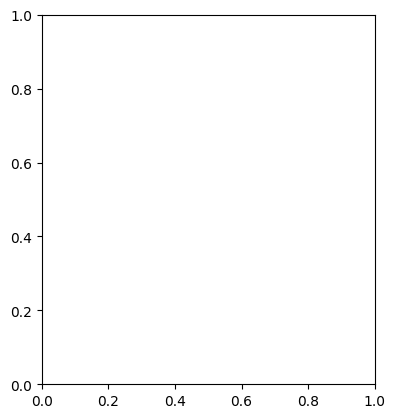

In [11]:
regions.plot('sector_name')

## Cargar datos del formulario

In [5]:
survey_answers = pd.read_csv('../respuestas_formulario.csv')

municipios = [
    'Apodaca',
    'Escobedo',
    'Garcia',
    'Guadalupe',
    'Juarez',
    'Monterrey',
    'San Nicolás de los Garza',
    'Santa Catarina',
    'San Pedro Garza García',
    'Agualeguas',
    'Allende',
    'Anahuac',
    'Aramberri',
    'Bustamante',
    'General Bravo',
    'Cerralvo',
    'Cienega',
    'China',
    'Dr Arroyo',
    'Dr. Coss',
    'Dr. Gonzalez',
    'El Carmen',
    'Abasolo',
    'Villaldama',
    'Hidalgo',
    'Gral Zuazua',
    'Gral. Zaragoza',
    'Gral Treviño',
    'Gral Terán',
    'Valecillo',
    'Santiago',
    'Salinas Victoria',
    'Sabinas Hidalgo',
    'Rayones',
    'Pesquería',
    'Parás',
    'Montemorelos',
    'Mina',
    'Mier y Noriega',
    'Melchor Ocampo',
    'Marín',
    'Los Ramones',
    'Las Herreras',
    'Los Aldamas',
    'Linares',
    'Lampazos',
    'Iturbide',
    'Hualahuises',
    'Galeana',
    'Cadereyta',
]

column_regex = re.compile(r'^.*\((.*)\)$')


def municipio_filter(column: str):
    match = column_regex.match(column)
    if match is not None:
        return match.group(1) in municipios
    else:
        return False


filtered_columns = list(filter(
    municipio_filter,
    survey_answers.columns))

organization_with_regions = survey_answers.filter(items=filtered_columns)

data = {'organization': [], 'sector_name': []}

for index, row in organization_with_regions.iterrows():
    organization = survey_answers['1. Nombre de la organización/colectivo/iniciativa:'][index]
    for value in row:
        if isinstance(value, str):
            sectors = value.split(',')
            for sector in sectors:
                data['organization'].append(organization)
                data['sector_name'].append(sector)

organization_region_names = pd.DataFrame(data=data)
organization_region_names


,organization,sector_name
0,geostats,Ebanos
1,geostats,Huinalá
2,geostats,Jardines de Primavera
3,geostats,Las Palmas
4,geostats,Mezquital
5,geostats,Sendero
6,geostats,Miravista
7,geostats,Acueducto
8,geostats,Oriente
9,NaN,Mezquital


<Axes: >

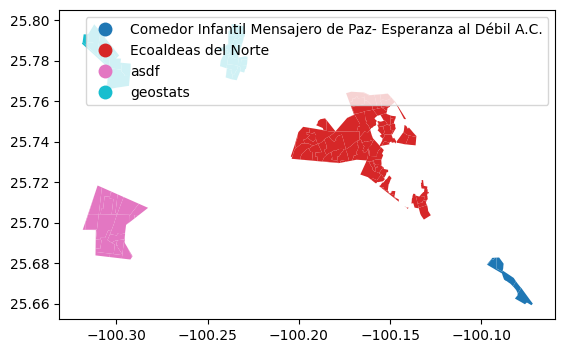

In [6]:
organization_regions = gpd.GeoDataFrame(organization_region_names.join(regions, on='sector_name', how='left'))
organization_regions.plot('organization', legend=True)

In [7]:
survey_answers.rename(columns={ '10. Coloca el año en que comenzaron sus actividades en Nuevo León: (independiente de tu año de constitución legal)': 'Starting_year','1. Nombre de la organización/colectivo/iniciativa:':'Organization_name'},inplace=True)


organization_with_year = survey_answers[['Organization_name', 'Starting_year']].copy()

organization_starting_year = pd.DataFrame(data=organization_with_year)
organization_starting_year


,Organization_name,Starting_year
0,NaN,NaN
1,geostats,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,Fundación Tarahumara José A. Llaguno,1992.0
7,Laboratorio de Innovación Social Tutores de Re...,2018.0
8,Comedor Infantil Mensajero de Paz- Esperanza a...,2015.0
9,Ecoaldeas del Norte,2019.0


In [9]:
survey_answers.rename(columns={ '3. Indica a cuál Objetivo de Desarrollo Sostenible (ODS) de la Agenda 2030 de la ONU contribuye tu organización/colectivo/iniciativa (solo una opción): [ODS 1. Fin de la pobreza.]': 'SDG_compliment'},inplace=True)


organization_with_ods = survey_answers[['Organization_name', 'SDG_compliment']].copy()

organization_ods_compliment = pd.DataFrame(data=organization_with_ods)
organization_ods_compliment

,Organization_name,SDG_compliment
0,NaN,NaN
1,geostats,"ODS 16. Paz, justicia e instituciones."
2,NaN,ODS 7. Energía asequible y no contaminante
3,NaN,ODS 1. Fin de la pobreza.
4,NaN,ODS 10. Reducción de las desigualdades.
5,NaN,ODS 2. Hambre cero.
6,Fundación Tarahumara José A. Llaguno,ODS 4. Educación de calidad.
7,Laboratorio de Innovación Social Tutores de Re...,"ODS 16. Paz, justicia e instituciones."
8,Comedor Infantil Mensajero de Paz- Esperanza a...,ODS 2. Hambre cero.
9,Ecoaldeas del Norte,ODS 15. Vida de ecosistemas terrestres.


In [13]:
survey_answers.rename(columns={ '3. Indica a cuál Objetivo de Desarrollo Sostenible (ODS) de la Agenda 2030 de la ONU contribuye tu organización/colectivo/iniciativa (solo una opción): [ODS 1. Fin de la pobreza.]': 'SDG_compliment'},inplace=True)


organization_with_ods = survey_answers[['Organization_name', 'SDG_compliment']].copy()

organization_ods_compliment = pd.DataFrame(data=organization_with_ods)
organization_ods_compliment

,Organization_name,SDG_compliment
0,NaN,NaN
1,geostats,"ODS 16. Paz, justicia e instituciones."
2,NaN,ODS 7. Energía asequible y no contaminante
3,NaN,ODS 1. Fin de la pobreza.
4,NaN,ODS 10. Reducción de las desigualdades.
5,NaN,ODS 2. Hambre cero.
6,Fundación Tarahumara José A. Llaguno,ODS 4. Educación de calidad.
7,Laboratorio de Innovación Social Tutores de Re...,"ODS 16. Paz, justicia e instituciones."
8,Comedor Infantil Mensajero de Paz- Esperanza a...,ODS 2. Hambre cero.
9,Ecoaldeas del Norte,ODS 15. Vida de ecosistemas terrestres.


In [14]:
survey_answers.rename(columns={ 'Indica cuál es el grupo de población objetivo (beneficiarios, usuarios) que atiende tu organización/colectivo/iniciativa. Puedes utilizar un máximo de 5-6 opciones para ser lo más específico posible:': 'Objective_group'},inplace=True)


organization_with_groups = survey_answers[['Organization_name', 'Objective_group']].copy()

organization_Objective_group = pd.DataFrame(data=organization_with_groups)
organization_Objective_group

,Organization_name,objective_group
0,NaN,NaN
1,geostats,"Niñas (6 a 11 años), Adolescentes hombres (15 ..."
2,NaN,"Niñas (6 a 11 años), Estudiantes, Madres solteras"
3,NaN,"Animales de compañía, Animales salvajes, Anima..."
4,NaN,"Pre adolescentes hombres (12 a 15 años), Adult..."
5,NaN,"Pre adolescentes hombres (12 a 15 años), Adole..."
6,Fundación Tarahumara José A. Llaguno,"Pre adolescentes mujeres (12 a 15 años), Pre a..."
7,Laboratorio de Innovación Social Tutores de Re...,"Primera infancia (0 a 5 años), Niños (6 a 11 a..."
8,Comedor Infantil Mensajero de Paz- Esperanza a...,Otros : Especificar lo más posible las caracte...
9,Ecoaldeas del Norte,"Estudiantes, Familias, Animales salvajes, Anim..."


In [16]:
survey_answers.rename(columns={ 'Qué productos o servicios ofrece tu organización a terceros (ya sea gratuito o con costo) ': 'Services'},inplace=True)


organization_with_services = survey_answers[['Organization_name', 'Services']].copy()

organization_services = pd.DataFrame(data=organization_with_services)
organization_services

,Organization_name,services
0,NaN,NaN
1,geostats,asdf
2,NaN,ASDF
3,NaN,lll
4,NaN,asdf
5,NaN,asdf
6,Fundación Tarahumara José A. Llaguno,NaN
7,Laboratorio de Innovación Social Tutores de Re...,NaN
8,Comedor Infantil Mensajero de Paz- Esperanza a...,NaN
9,Ecoaldeas del Norte,NaN


In [17]:
survey_answers.rename(columns={ '4. Indica cuáles son las 3 principales actividades que realiza tu organización/colectivo/iniciativa': 'Activities'},inplace=True)


organization_with_activities = survey_answers[['Organization_name', 'Activities']].copy()

organization_activities = pd.DataFrame(data=organization_with_activities)
organization_activities

,Organization_name,Activities
0,NaN,NaN
1,geostats,"Salud, Educativas, Ecológicos, Apoyo económico"
2,NaN,Promoción y aportación de servicios para la sa...
3,NaN,NaN
4,NaN,"Equidad y género, Promoción y aportación de se..."
5,NaN,"Equidad y género, Promoción y aportación de se..."
6,Fundación Tarahumara José A. Llaguno,"Educativas, Apoyo económico, Desarrollo Social"
7,Laboratorio de Innovación Social Tutores de Re...,"Educativas, Investigación, Culturales (danza, ..."
8,Comedor Infantil Mensajero de Paz- Esperanza a...,"Asistenciales (Alimentación, vestido, vivienda..."
9,Ecoaldeas del Norte,"Protección del medio ambiente, Ciencia y tecno..."


In [18]:
survey_answers.rename(columns={ '2. Selecciona el número de personas voluntarias totales (recurrentes o esporádicos) que tu organización/colectivo/iniciativa tuvo en el año 2022:': 'Volunteers'},inplace=True)


organization_with_volunteers = survey_answers[['Organization_name', 'Volunteers']].copy()

organization_volunteers = pd.DataFrame(data=organization_with_volunteers)
organization_volunteers

,Organization_name,Volunteers
0,NaN,NaN
1,geostats,6 a 10
2,NaN,21 a 50
3,NaN,21 a 50
4,NaN,6 a 10
5,NaN,51 a 100
6,Fundación Tarahumara José A. Llaguno,21 a 50
7,Laboratorio de Innovación Social Tutores de Re...,51 a 100
8,Comedor Infantil Mensajero de Paz- Esperanza a...,Más de 250
9,Ecoaldeas del Norte,21 a 50


In [19]:
survey_answers.rename(columns={ '1. Selecciona el número de integrantes con nómina o remunerados económicamente con los que cuenta tu organización/colectivo/iniciativa al día de hoy:': 'Employee'},inplace=True)


organization_with_employees = survey_answers[['Organization_name', 'Employee']].copy()

organization_employee = pd.DataFrame(data=organization_with_employees)
organization_employee

,Organization_name,Employee
0,NaN,NaN
1,geostats,1 a 5
2,NaN,6 a 10
3,NaN,1 a 5
4,NaN,1 a 5
5,NaN,1 a 5
6,Fundación Tarahumara José A. Llaguno,21 a 50
7,Laboratorio de Innovación Social Tutores de Re...,0
8,Comedor Infantil Mensajero de Paz- Esperanza a...,6 a 10
9,Ecoaldeas del Norte,0
